# IceCube - EDA

## Load Data

In [1]:
%cd ..

/home/jovyan/ice-cube


In [2]:
import sys

sys.path.append(".")

In [3]:
import logging

logging.basicConfig(
    # filename=__file__.replace('.py', '.log'),
    level=logging.getLevelName("INFO"),
    format="%(asctime)s [%(levelname)s] [%(module)s] %(message)s",
)

log = logging.getLogger(__name__)

In [4]:
import glob
import math
import os
import re

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import scipy.stats as stats
import seaborn as sns
from omegaconf import OmegaConf
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage

# from pandas_profiling import ProfileReport

# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_colwidth", None)

In [5]:
from src.load_data import LoadData
from src.preprocesses.cache import fit_instance, transform_data
from src.preprocesses.p001_dist_transformer import DistTransformer
from src.utils import choice_seed, df_stats, fix_seed

# from src.get_score import get_score

In [6]:
# Competition specific packages
import os
import sqlite3
from typing import Any, Dict, List, Optional

import pyarrow.parquet as pq
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# import sqlalchemy
# import graphnet
# from graphnet.data.sqlite.sqlite_utilities import create_table

In [7]:
c_main = OmegaConf.load("./config/main.yaml")
c_data = OmegaConf.load("./config/data.yaml")
c = OmegaConf.merge(c_main, c_data)

fix_seed(choice_seed(c))

2023-02-28 05:49:48,076 [INFO] [utils] Fix seed: 440


In [8]:
input = LoadData(c, use_fold=False, do_preprocess=False)

2023-02-28 05:49:48,082 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/train_meta.parquet
2023-02-28 05:49:55,828 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/test_meta.parquet
2023-02-28 05:49:55,834 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/sample_submission.parquet
2023-02-28 05:49:55,837 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv


In [9]:
[col for col in dir(input) if not col.startswith("__")]

['c', 'sample_submission', 'sensor_geometry', 'test_meta', 'train_meta']

## Check Data

In [10]:
input.sample_submission.shape

(3, 3)

In [11]:
input.sample_submission

,event_id,azimuth,zenith
0,2092,1,1
1,7344,1,1
2,9482,1,1


In [12]:
input.sensor_geometry.shape

(5160, 4)

In [13]:
input.sensor_geometry

,sensor_id,x,y,z
0,0,-256.14,-521.08,496.03
1,1,-256.14,-521.08,479.01
2,2,-256.14,-521.08,461.99
3,3,-256.14,-521.08,444.97
4,4,-256.14,-521.08,427.95
...,...,...,...,...
5155,5155,-10.97,6.72,-472.39
5156,5156,-10.97,6.72,-479.39
5157,5157,-10.97,6.72,-486.40
5158,5158,-10.97,6.72,-493.41


In [92]:
input.sensor_geometry.describe()

,sensor_id,x,y,z
count,5160.000000,5160.000000,5160.000000,5160.000000
mean,2579.500000,5.870829,-2.518609,-23.905766
std,1489.708025,285.151213,269.409729,296.456563
min,0.000000,-570.900000,-521.080000,-512.820000
25%,1289.750000,-224.090000,-209.070000,-283.200000
50%,2579.500000,16.990000,-6.055000,-35.115000
75%,3869.250000,224.580000,211.660000,228.557500
max,5159.000000,576.370000,509.500000,524.560000


In [14]:
input.test_meta.shape

(3, 4)

In [15]:
input.test_meta

,batch_id,event_id,first_pulse_index,last_pulse_index
0,661,2092,0,298
1,661,7344,299,334
2,661,9482,335,377


In [16]:
input.train_meta.shape

(131953924, 6)

In [17]:
input.train_meta

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
0,1,24,0,60,5.029555,2.087498
1,1,41,61,111,0.417742,1.549686
2,1,59,112,147,1.160466,2.401942
3,1,67,148,289,5.845952,0.759054
4,1,72,290,351,0.653719,0.939117
...,...,...,...,...,...,...
131953919,660,2147483597,24339210,24339349,5.895612,0.333071
131953920,660,2147483603,24339350,24339383,3.273695,1.503301
131953921,660,2147483617,24339384,24339424,2.945376,1.723253
131953922,660,2147483626,24339425,24339499,1.616582,1.937025


In [18]:
input.train_meta[input.train_meta["batch_id"] == 660]

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
131800000,660,2144984130,0,48,3.529914,2.550824
131800001,660,2144984139,49,112,3.207535,2.059141
131800002,660,2144984142,113,265,4.151043,1.442473
131800003,660,2144984185,266,323,1.919508,1.337062
131800004,660,2144984191,324,384,2.112190,0.730649
...,...,...,...,...,...,...
131953919,660,2147483597,24339210,24339349,5.895612,0.333071
131953920,660,2147483603,24339350,24339383,3.273695,1.503301
131953921,660,2147483617,24339384,24339424,2.945376,1.723253
131953922,660,2147483626,24339425,24339499,1.616582,1.937025


## Read single batch

In [60]:
batch_num = 661
batch = pd.read_parquet(
    os.path.join(c.data.dir.input_test, f"batch_{batch_num}.parquet")
).reset_index()

In [61]:
batch.shape

(378, 5)

In [62]:
batch.loc[0:298, :]

,event_id,sensor_id,time,charge,auxiliary
0,2092,4066,6170,1.275,True
1,2092,3512,6374,0.975,True
2,2092,897,6378,1.475,True
3,2092,2060,6590,0.925,True
4,2092,3072,6625,1.075,True
...,...,...,...,...,...
294,2092,4998,22868,1.125,True
295,2092,2152,24147,0.925,True
296,2092,3229,24502,0.525,True
297,2092,5156,25399,0.875,True


In [63]:
batch["charge"].describe(percentiles=[0.1, 0.9])

count    378.000000
mean       0.989947
std        0.465175
min        0.125000
10%        0.475000
50%        0.975000
90%        1.475000
max        4.775000
Name: charge, dtype: float64

In [68]:
batch_num = 1
batch = pd.read_parquet(
    os.path.join(c.data.dir.input_train, f"batch_{batch_num}.parquet")
).reset_index()

In [69]:
batch.shape

(32792416, 5)

In [70]:
batch

,event_id,sensor_id,time,charge,auxiliary
0,24,3918,5928,1.325,True
1,24,4157,6115,1.175,True
2,24,3520,6492,0.925,True
3,24,5041,6665,0.225,True
4,24,2948,8054,1.575,True
...,...,...,...,...,...
32792411,3266196,1961,17617,0.975,True
32792412,3266196,36,17705,0.625,True
32792413,3266196,356,18192,0.725,True
32792414,3266196,2826,18609,0.575,True


In [71]:
batch["event_id"].unique().shape

(200000,)

In [73]:
max(batch["charge"])

2762.02490234375

In [74]:
batch["charge"].describe(percentiles=[0.05, 0.9])

count    3.279242e+07
mean     3.908981e+00
std      1.628897e+01
min      2.500000e-02
5%       3.750000e-01
50%      1.075000e+00
90%      5.375000e+00
max      2.762025e+03
Name: charge, dtype: float64

In [75]:
batch = pd.merge(batch, input.sensor_geometry, on="sensor_id")

In [76]:
batch

,event_id,sensor_id,time,charge,auxiliary,x,y,z
0,24,3918,5928,1.325,True,303.41,335.64,206.58
1,2743,3918,10813,0.975,True,303.41,335.64,206.58
2,3007,3918,10290,0.925,False,303.41,335.64,206.58
3,3007,3918,10515,0.625,False,303.41,335.64,206.58
4,3007,3918,10688,0.925,False,303.41,335.64,206.58
...,...,...,...,...,...,...,...,...
32792411,3261719,1835,15175,0.475,True,-570.90,-125.14,-96.12
32792412,3263862,1835,23327,1.075,False,-570.90,-125.14,-96.12
32792413,3263862,1835,23522,0.575,False,-570.90,-125.14,-96.12
32792414,3264992,1835,13440,1.025,False,-570.90,-125.14,-96.12


## Single Event

In [77]:
event_id = 67

In [78]:
azimuth_event = input.train_meta[input.train_meta["event_id"] == event_id][
    "azimuth"
].to_numpy()
zenith_event = input.train_meta[input.train_meta["event_id"] == event_id][
    "zenith"
].to_numpy()
azimuth_event, zenith_event

(array([5.845952]), array([0.75905357]))

In [79]:
line_x = math.cos(azimuth_event) * math.sin(zenith_event)
line_x_details = (-line_x * 500, line_x * 500)
line_y = math.sin(azimuth_event) * math.sin(zenith_event)
line_y_details = (-line_y * 500, line_y * 500)
line_z = math.cos(zenith_event)
line_z_details = (-line_z * 500, line_z * 500)
line_color, line_style, line_width = "r", "-", 2

In [80]:
batch_event = batch[(batch["event_id"] == event_id)]
# batch_event = batch[(batch["event_id"] == event_id) & (batch["auxiliary"] == False)]
batch_event.shape

(142, 8)

In [81]:
batch_event.head()

,event_id,sensor_id,time,charge,auxiliary,x,y,z
279978,67,4904,9858,2.625,True,106.94,27.09,-399.05
599154,67,1287,20198,0.675,True,-492.43,-230.16,38.04
605137,67,4685,19231,0.775,False,31.25,-72.93,138.23
605138,67,4685,19389,1.175,False,31.25,-72.93,138.23
775168,67,5060,6751,0.675,True,-9.68,-79.50,-226.50


In [82]:
batch_event.describe()

,event_id,sensor_id,time,charge,x,y,z
count,142.0,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
mean,67.0,2836.105634,17192.866197,0.927817,-47.938521,-63.416268,-61.006127
std,0.0,1646.771192,5389.187276,0.578999,230.748360,218.481684,258.722186
min,67.0,76.000000,6751.000000,0.125000,-526.630000,-501.450000,-504.630000
25%,67.0,1568.000000,11867.750000,0.675000,-279.530000,-131.250000,-316.372500
50%,67.0,2595.500000,19184.000000,0.875000,-9.680000,-72.930000,-41.120000
75%,67.0,4680.000000,21077.000000,1.075000,112.527500,23.170000,161.932500
max,67.0,5118.000000,27144.000000,5.125000,576.370000,509.500000,415.570000


In [83]:
batch_event["auxiliary"].value_counts()

True     85
False    57
Name: auxiliary, dtype: int64

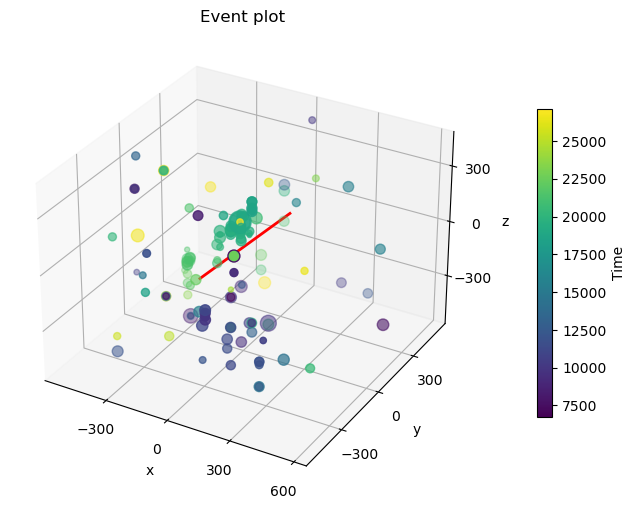

In [84]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")
ax.set_title("Event plot")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xticks([-600, -300, 0.0, 300, 600])
ax.set_yticks([-600, -300, 0.0, 300, 600])
ax.set_zticks([-600, -300, 0.0, 300, 600])

# 散布図を描画
scatter = ax.scatter(
    batch_event["x"],
    batch_event["y"],
    batch_event["z"],
    s=batch_event["charge"] * 50,
    c=batch_event["time"],
)

ax.plot3D(
    xs=line_x_details,
    ys=line_y_details,
    zs=line_z_details,
    color=line_color,
    linestyle=line_style,
    linewidth=line_width,
)


cbar = fig.colorbar(scatter, shrink=0.5, pad=0.1)
cbar.set_label("Time")

plt.show()

### 階層的クラスタリング

In [85]:
h_cluster = linkage(batch_event[["time", "charge", "x", "y", "z"]])

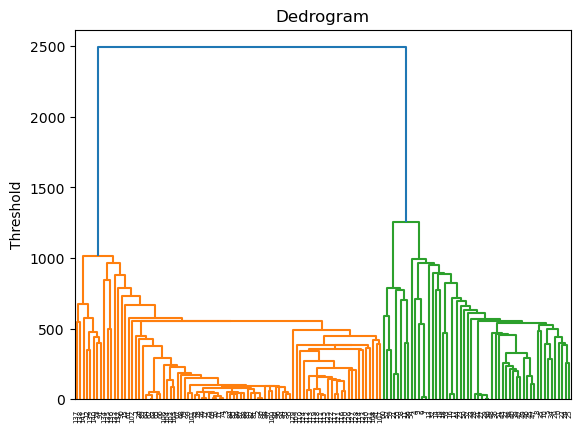

In [86]:
dendrogram(h_cluster)
plt.title("Dedrogram")
plt.ylabel("Threshold")
plt.show()

In [87]:
batch_event.loc[:, "h_labels"] = fcluster(h_cluster, 1)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [88]:
batch_event["h_labels"].value_counts()

13    11
42     8
14     8
48     6
2      6
      ..
39     1
51     1
56     1
36     1
17     1
Name: h_labels, Length: 63, dtype: int64

In [89]:
batch_event_ = batch_event[batch_event.duplicated(subset=["h_labels"], keep=False)]

In [90]:
batch_event_.shape

(111, 9)

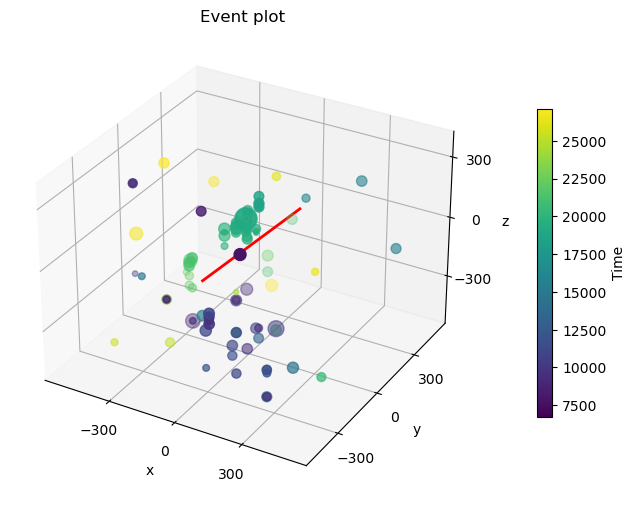

In [91]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")
ax.set_title("Event plot")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xticks([-600, -300, 0.0, 300, 600])
ax.set_yticks([-600, -300, 0.0, 300, 600])
ax.set_zticks([-600, -300, 0.0, 300, 600])

# 散布図を描画
scatter = ax.scatter(
    batch_event_["x"],
    batch_event_["y"],
    batch_event_["z"],
    s=batch_event_["charge"] * 50,
    c=batch_event_["time"],
)

ax.plot3D(
    xs=line_x_details,
    ys=line_y_details,
    zs=line_z_details,
    color=line_color,
    linestyle=line_style,
    linewidth=line_width,
)


cbar = fig.colorbar(scatter, shrink=0.5, pad=0.1)
cbar.set_label("Time")

plt.show()